## Introduction

The Titanic Kaggle challenge is a good introduction to data science. At the time of this writing, the best tutorials seem to be written in R. To help teach myself Python/Pandas, I borrowed heavily from [Bisaria's lasso/ridge implementation in R](https://www.kaggle.io/svf/272035/c7674afa411b198f92611a43fe7d7c75/__results__.html#lasso-and-ridge-models).  

In this notebook, we predict survivors in the Titanic dataset using lasso and ridge regression methods. Early exploration of data divulges huge disparity in survival ratio between men and women, we trained separate models for men and women. Many observations had the Age variable missing, so we used Multiple Imputation by Chained Equations to impute missing age.

The final result was [...] on the public leaderboard.

### Imports

In [936]:
%matplotlib inline

import re

import pandas as pd
import numpy as np
import csv as csv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics import mosaicplot
from sklearn.tree import DecisionTreeRegressor
import fancyimpute 

pd.set_option('precision', 2)
matplotlib.style.use('ggplot')

### Load Data

In [937]:
train = pd.read_csv('train.csv', header=0)
test = pd.read_csv('test.csv', header=0)

## Exploratory Data Analysis
Let's take a quick peek into the dataset.

In [938]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [939]:
train.describe()

/Users/hkwik/anaconda/envs/py35/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,446.00,0.38,2.31,29.70,0.52,0.38,32.20
std,257.35,0.49,0.84,14.53,1.10,0.81,49.69
min,1.00,0.00,1.00,0.42,0.00,0.00,0.00
25%,223.50,0.00,2.00,NaN,0.00,0.00,7.91
50%,446.00,0.00,3.00,NaN,0.00,0.00,14.45
75%,668.50,1.00,3.00,NaN,1.00,0.00,31.00
max,891.00,1.00,3.00,80.00,8.00,6.00,512.33


Frequency table of Survived vs. Sex:

In [940]:
pd.crosstab(train.Survived, train.Sex)

Sex,female,male
Survived,,
0,81,468
1,233,109


In [941]:
pd.crosstab(train.Survived, train.Sex, normalize=True)

Sex,female,male
Survived,,
0,0.09,0.53
1,0.26,0.12


We see 891 passeengers in the training data, comprising of 314 female and 577 male passengers, out of which 233 females and 109 males survived the disaster. The dataset provides information about each passenger's name, age, gender, port of embarkation, which cabin they booked, their ticket number and fare they paid along with the number of family members they were traveling with. Some of the data like Age and Cabin have a fair amount of missing values, which we'll ignore in our initial exploration of the data.

### Did age influence survival?
Let's look at a scatterplot of the ages of each passenger. This shows that while most of the casualties were male, those below the age of 15 seemed to have a similar survival rate as females within that age group. Females 50 and older seem to have a better survival rate, whereas males 50 and older seem to be worse off than their middle-aged male counterparts. 

We'll use this information when we create new features based on age. 

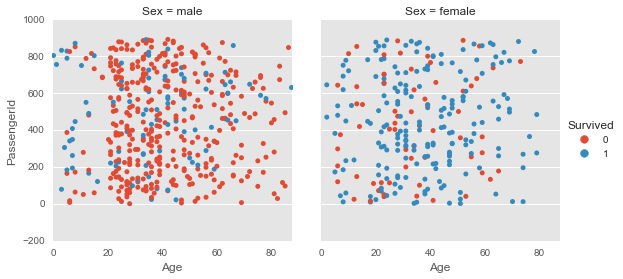

In [942]:
g = sns.factorplot(x='Age', y='PassengerId', hue='Survived', col='Sex', kind='strip', data=train);
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=20))
plt.show()

### Is survival related to a passenger's class and/or port of embarkation?
Since passengers traveled in different classes, let's check to see if there's any correlation between travel class, where they boarded, and survival.

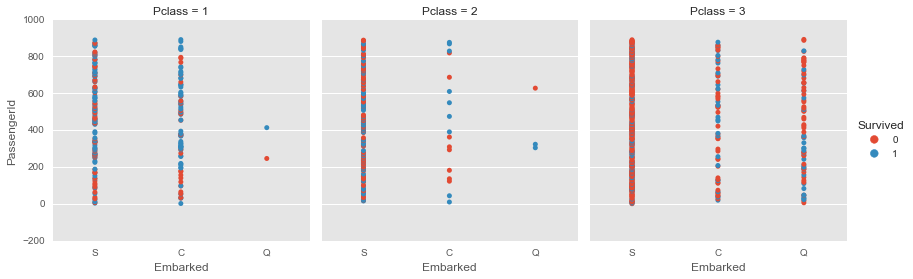

In [943]:
sns.factorplot(x="Embarked", y="PassengerId", hue="Survived", col="Pclass", kind="strip", data=train);

Most of the passengers who perished had embarked from port ‘S’ and were travelling 3rd class.

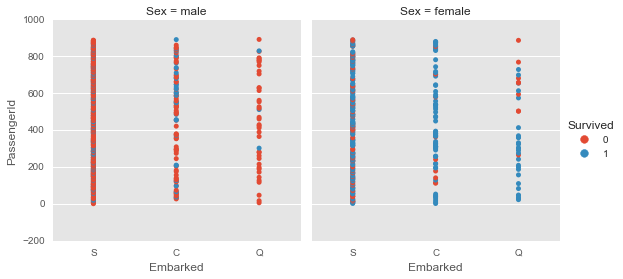

In [944]:
sns.factorplot(x="Embarked", y="PassengerId", hue="Survived", col="Sex", kind="strip", data=train);

Looks like most of the unfortunate passengers from port ‘S’ travelling 3rd class were male, while most of the casualties among females also happened among passengers from the port ‘S’.

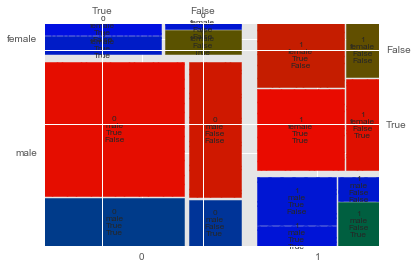

In [945]:
# TODO: Probably kill this, because I'm having trouble making a mosaic that looks useful.
# Perhaps ask StackOverflow

train.loc[:, 'AgeGt15'] = train['Age'] > 15 
train.loc[:, 'WithFamily'] = train['SibSp'] + train['Parch'] > 0

mosaicplot.mosaic(train, ['Survived', 'Sex', 'AgeGt15', 'WithFamily'], gap=0.05, statistic = True); 

# Try labeling to see it this makes it more clear
# try changing True False to more descriptive labels


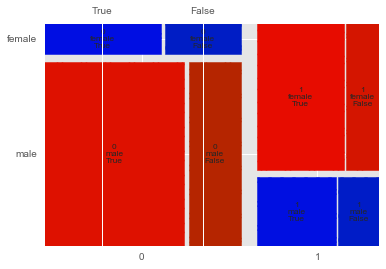

In [946]:
mosaicplot.mosaic(train, ['Survived', 'Sex', 'AgeGt15'], gap = 0.05, statistic = True);

Finally, a combined dataframe of training and test data is created, with 'Survived' removed from the train dataset and saved separately. This will be added to the train dataset after further processing of the combined dataset.

In [947]:
train = train.drop(['AgeGt15', 'WithFamily'], axis=1)

survived = train['Survived']

test['Survived'] = 0

all_titanic = train.append(test)

## Feature Engineering

### Title
The names of the passengers include titles, which we can then use to infer social status. Perhaps passengers with higher social status were more likely to surive. We also look at the minimum and maximum age for each title in our dataset, so we can then infer title when we impute the missing ages. 

In [948]:
def create_titles(names):
    return [re.split(', |\. ', name)[1] for name in all_titanic.Name]
    
def title_dist():
    unique_titles = all_titanic['Title'].unique()
    n_passengers = [sum(all_titanic['Title'] == title) for title in unique_titles]
    age_missing = [sum((all_titanic['Title'] == title) & (pd.isnull(all_titanic['Age']))) for title in unique_titles]
    min_age = [min(all_titanic.loc[all_titanic['Title'] == title, 'Age']) for title in unique_titles]
    max_age = [max(all_titanic.loc[all_titanic['Title'] == title, 'Age']) for title in unique_titles]

    title_dist = pd.DataFrame({'Title': unique_titles, 'NumPassengers': n_passengers, 'AgeMissing': age_missing, 'MinAge': min_age, 'MaxAge': max_age})
    title_dist.columns.tolist()

    return(title_dist[['Title', 'NumPassengers', 'AgeMissing', 'MinAge', 'MaxAge']])

all_titanic['Title'] = create_titles(all_titanic.Name)
title_dist()

,Title,NumPassengers,AgeMissing,MinAge,MaxAge
0,Mr,757,176,11.00,80.0
1,Mrs,197,27,14.00,76.0
2,Miss,260,50,0.17,63.0
3,Master,61,8,0.33,14.5
4,Don,1,0,40.00,40.0
5,Rev,8,0,27.00,57.0
6,Dr,8,1,23.00,54.0
7,Mme,1,0,24.00,24.0
8,Ms,2,1,28.00,28.0
9,Major,2,0,45.00,52.0


These eighteen categories can be condensed into five categories based on title and age:

* Mr: For men older than 14.5 years of age
* Master: For boys above less than or equal to 14.5 years of age
* Miss: For girls less than or equal to 14.5 years of age
* Ms: For women above 14.5 years of age
* Mrs: For married women above 14.5 years

In [949]:
def condense_titles(df):
    df.loc[(df['Title'] == 'Mr') & 
        (df['Age'] <= 14.5) & 
        (pd.notnull(df['Age'])), 'Title'] = 'Master'

    df.loc[(df['Title'] == 'Capt') |
            (df['Title'] == 'Col') |
            (df['Title'] == 'Don') |
            (df['Title'] == 'Major') |
            (df['Title'] == 'Rev') |
            (df['Title'] == 'Jonkheer') |
            (df['Title'] == 'Sir'), 'Title'] = 'Mr'

    # None of these women are traveling with family, so they can be
    # categorized as single women for this analysis.
    df.loc[(df['Title'] == 'Dona') |
            (df['Title'] == 'Mlle') |
            (df['Title'] == 'Mme'), 'Title'] = 'Ms'

    # Categorize Lady and Countess as married women
    df.loc[(df['Title'] == 'Lady') | (df['Title'] == 'the Countess'), 'Title'] = 'Mrs'

    # Categorize doctors per their sex
    df.loc[(df['Title'] == 'Dr') & (df['Sex'] == 'female'), 'Title'] = 'Ms'
    df.loc[(df['Title'] == 'Dr') & (df['Sex'] == 'male'), 'Title'] = 'Mr'
    
    return(df)

all_titanic = condense_titles(all_titanic)


In [950]:
title_dist()

,Title,NumPassengers,AgeMissing,MinAge,MaxAge
0,Mr,777,177,15.00,80.0
1,Mrs,199,27,14.00,76.0
2,Miss,260,50,0.17,63.0
3,Master,66,8,0.33,14.5
4,Ms,7,1,24.00,49.0


### FamilySize
FamilySize is based on the number of family members traveling with a passenger.

In [951]:
# Small = True, Big = False
all_titanic['FamilySize'] = (all_titanic['SibSp'] + all_titanic['Parch']) <= 3
all_titanic['FamilySize'] = all_titanic['FamilySize'].astype(int)

### Mother
Identify the ladies traveling with their children.

In [952]:
all_titanic['Mother'] = (all_titanic['Title'] == 'Mrs') & (all_titanic['Parch'] > 0)
all_titanic['Mother'] = all_titanic['Mother'].astype(int)

### Single
Identify people traveling solo.

In [953]:
all_titanic['Single'] = all_titanic['SibSp'] + all_titanic['Parch'] + 1 == 1
all_titanic['Single'] = all_titanic['Single'].astype(int)

### Family Name
The family name of each individual can be extracted from their names. 

In [954]:
all_titanic['FamilyName'] = [re.split(', ', name)[0] for name in all_titanic['Name']]

Since there are possibly many people sharing the same family name, it's necessary to distinguish family separately.

In [955]:
family_ticket = all_titanic.loc[all_titanic['Single'] == 0, ['FamilyName', 'Ticket']]
family_ticket = family_ticket.sort_values('FamilyName')
family_ticket.head()

,FamilyName,Ticket
746,Abbott,C.A. 2673
392,Abbott,C.A. 2673
279,Abbott,C.A. 2673
874,Abelson,P/PP 3381
308,Abelson,P/PP 3381


Barring few exceptions, in general, a family shared the same ticket number. This can be a good way of identifying families. Here, we extract the last three digits of the ticket and attach it to the family name, thereby creating unique family names per family.

In [956]:
last_digits = [ticket[-3:] for ticket in all_titanic['Ticket']]
all_titanic['FamilyName'] = all_titanic['FamilyName'] + last_digits

### Family Survived
Based on the exploratory analysis, a feature representing the survival of family can be created. Families traveling together may have tried to escape together and their survival would be closely tied to each other.

In [957]:
all_titanic['FamilySurvived'] = 0

# DataFrame of all passengers with family
families = all_titanic.loc[all_titanic['Parch'] + all_titanic['SibSp'] > 0, ]

# Group families by their family name and number of survivals in the family
by_family_name = families.groupby(['FamilyName'])
family_name_survived = by_family_name['Survived'].sum()

In [958]:
# Family is considered to have survived if at least one member survived
family_name_survived = family_name_survived[family_name_survived > 0]
survived_names = family_name_survived.index.values
all_titanic.loc[all_titanic['FamilyName'].isin(survived_names), 'FamilySurvived'] = 1


### AgeClass
We can categorize Age into four classes:
* Class 1: 10 and below
* Class 2: Above 10 and less than equal to 20
* Class 3: Above 20 and less than equal to 35
* Class 4: Above 35

Since Age is missing for many observations, there will be some data missing here too, which can be calculated after imputing Age.

In [959]:
all_titanic['AgeClass'] = 0
all_titanic.loc[all_titanic['Age'] <= 10, 'AgeClass'] = 1
all_titanic.loc[(all_titanic['Age'] > 10) & (all_titanic['Age'] <= 20), 'AgeClass'] = 2
all_titanic.loc[(all_titanic['Age'] > 20) & (all_titanic['Age'] <= 35), 'AgeClass'] = 3
all_titanic.loc[all_titanic['Age'] >= 35, 'AgeClass'] = 4

## Imputing missing data
Let's find out which columns have missing data:

In [960]:
cols = [col for col in all_titanic.columns if col not in ['Survived', 'Name', 'PassengerId', 'Ticket', 'AgeClass']]
all_titanic[cols].isnull().sum()

Age                263
Cabin             1014
Embarked             2
Fare                 1
Parch                0
Pclass               0
Sex                  0
SibSp                0
Title                0
FamilySize           0
Mother               0
Single               0
FamilyName           0
FamilySurvived       0
dtype: int64

There are 263 observations where Age is missing, 1014 observations have Cabin missing, 2 observations with Embarked missing, and 1 observation with Fare missing.

### Embarked 
Two of the passengers have information about their port of embarkation missing. These two observations belong two female passengers who survived and were traveling first class in a B cabin. Since most of the females in first class who survived embarked either from Southampton or Cherbourg and the mode of Embarked is S, we'll assume they embarked at Southampton.

In [961]:
all_titanic.loc[pd.isnull(all_titanic['Embarked']), 'Embarked'] = 'S'

### Fare
We'll use a decision tree to predict the one missing fare observation, using other features as predictors.

Before doing this, we need to create dummies for our categorical variables.

In [ ]:
ports = pd.get_dummies(all_titanic['Embarked'])
titles = pd.get_dummies(all_titanic['Title'])

all_titanic = pd.concat([all_titanic, ports, titles], axis = 1)
all_titanic = all_titanic.drop(['Embarked', 'Title'], axis = 1)

# NOTE: IF THIS AFFECTS THE ACTUAL RESULTS, THEN TRY DOING SOMETHING SMARTER WITH THE MISSING AGE.

In [ ]:
features = ['Pclass', 'SibSp', 'Parch', 'C', 'Q', 'S', 'Master', 'Miss', 'Mr', 'Mrs', 'Ms']

all_fares = all_titanic.loc[pd.notnull(all_titanic['Fare'])]
missing_fare = all_titanic.loc[pd.isnull(all_titanic['Fare'])]

# # Impute Age using mean
# # Create an imputer
# imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
# # Fit and transform it on the Ages
# new_ages = imp.fit_transform(all_fares['Age'])

# # Set the Age column to this new array
# all_fares['Age'] = new_ages.transpose()
# all_fares['Age']

#Create decision tree Regressor
clf = DecisionTreeRegressor(random_state=0)

X = all_fares[features]
y = all_fares['Fare']
clf.fit(X, y)

# # Predict fare based on this
#missing_fare[features]
all_titanic.loc[pd.isnull(all_titanic['Fare']), 'Fare'] = clf.predict(missing_fare[features])

### Age
We noticed earlier that 263 passengers have missing ages. We will use multiple chaining

In [ ]:
pd.crosstab(pd.isnull(all_titanic['Age']), all_titanic.Pclass)

Pclass,1,2,3
Age,,,
False,284,261,501
True,39,16,208


In [ ]:
impute_missing = all_titanic.drop(['Survived', 'Name', 'PassengerId', 'Ticket', 'AgeClass', 'Cabin', 'FamilyName'], axis=1)

impute_missing['Sex'] = impute_missing['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
filled_soft = fancyimpute.MICE(n_imputations=20, impute_type='pmm').complete(np.array(impute_missing))

Let's compare the original distribution of ages vs. the imputed ages:

In [ ]:
imputed_ages = pd.DataFrame(filled_soft, columns = list(impute_missing))
sns.kdeplot(imputed_ages['Age'], label = 'imputed')
ax = sns.kdeplot(all_titanic['Age'], label = 'original')
ax.set(xlabel='Age', ylabel='Density');

The imputed data seems to be acceptable, so we'll use it for filling in the missing values in AgeClass and Title.

In [ ]:
all_titanic['Age'] = imputed_ages['Age']

# Fill in missing age class
all_titanic.loc[all_titanic['Age'] <= 10, 'AgeClass'] = 1
all_titanic.loc[(all_titanic['Age'] > 10) & (all_titanic['Age'] <= 20), 'AgeClass'] = 2
all_titanic.loc[(all_titanic['Age'] > 20) & (all_titanic['Age'] <= 35), 'AgeClass'] = 3
all_titanic.loc[all_titanic['Age'] >= 35, 'AgeClass'] = 4

# Fill in missing titles

# Drop the dummies title columns
all_titanic = all_titanic.drop(list(titles), axis = 1)

# Redo the titles
all_titanic['Title'] = create_titles(all_titanic['Name'])
all_titanic = condense_titles(all_titanic)

# TODO(hkwik): May need to revisit this based on the crosstab, Mrs. looks problematic
# Another alternative may be to try different parameters on imputation. We'll see what the results look like
print(pd.crosstab(all_titanic['Title'], all_titanic['Age'] > 14.5))
all_titanic.loc[(all_titanic['Title'] == 'Master') & (all_titanic['Age'] > 14.5), 'Title'] = 'Mr'
all_titanic.loc[(all_titanic['Title'] == 'Miss') & (all_titanic['Age'] > 14.5), 'Title'] = 'Ms'
all_titanic.loc[(all_titanic['Title'] == 'Mr') & (all_titanic['Age'] <= 14.5), 'Title'] = 'Master'
print(pd.crosstab(all_titanic['Title'], all_titanic['Age'] > 14.5))

# Drop the title column and re-add the dummies
titles = pd.get_dummies(all_titanic['Title'])
all_titanic = pd.concat([all_titanic, titles], axis = 1)
all_titanic = all_titanic.drop(['Title'], axis = 1)